In [1]:
# 한글폰트 불러오기
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False
print("done")

done


# 데이터 수집

직사각형 범위 (A2 사이즈)의 꼭짓점 부분에 ESP32 1개와 각각 연결된 초음파센서 4개를 서로 마주보게 배치하고, 안에 있는 물체를 멈춰있게 또는 느리게 하면 (1), 빠르게 (2), 물체가 없게 (0)로 직접 레이블링 하여 데이터셋을 준비함. (총 변화량을 계산하여 기준을 정한 뒤 레이블링 하는 방법도 있을 것 같지만 현재 프로젝트에서는 정확한 기준은 없이 진행함)

데이터는 0.2초마다 한 번씩 저장됨

timestamp, label, ESP32-1, ESP32-2, ESP32-3, ESP32-4 속성이 있음.

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('datasets/datasets/251127_New_labeled_NH-001_301A.csv')
print("CSV file loaded successfully. First 5 rows:")
print(df.head())

CSV file loaded successfully. First 5 rows:
                 timestamp  label  ESP32-1  ESP32-2  ESP32-3  ESP32-4
0  2025-11-27 12:10:10.922      0       16       14       17       15
1  2025-11-27 12:10:11.122      0       48       46       36       47
2  2025-11-27 12:10:11.322      0       42       47       44       48
3  2025-11-27 12:10:11.522      0       48       47       35       48
4  2025-11-27 12:10:11.722      0       50       47       35       48


/tmp/ipykernel_62898/2214834888.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


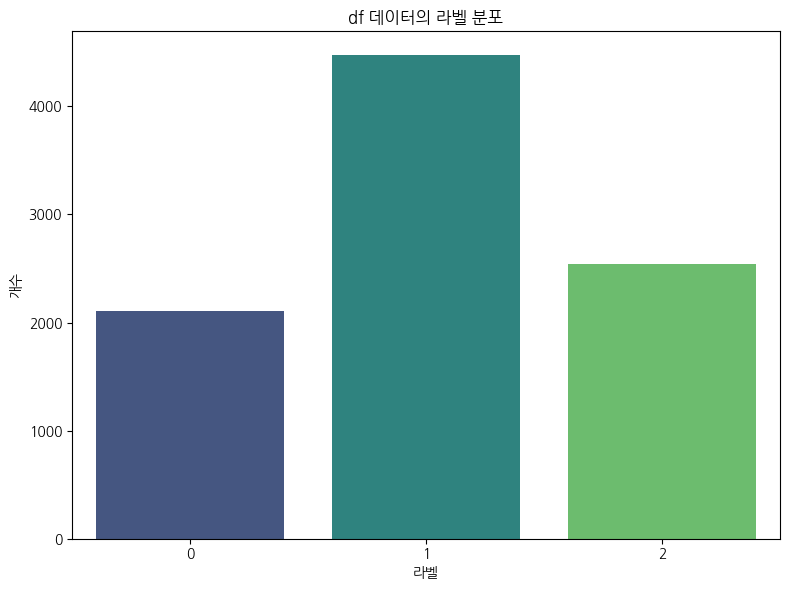

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the value counts of the 'label' column
label_counts = df['label'].value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('df 데이터의 라벨 분포')
plt.xlabel('라벨')
plt.ylabel('개수')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 데이터 전처리
-값을 측정하고 저장하는 단계에서 윈도우 사이즈를 설정하여 초음파센서값이 튀는 것을 방지함. (최근 3개의 데이터를 기준으로 값이 정해지게 하고, 한 번에 점프를 허용하는 길이는 건너편 초음파 센서가 있는 거리보다 작거나 같게)

-데이터셋을 저장할 때 센서값 3개 이상이 있어야 저장되는 조건을 걸어 전처리가 용이하게 만듦.

## 0, -1, 비어있는 열을 NaN으로 변환

In [4]:
esp_columns = [col for col in df.columns if col.startswith('ESP32-')]

for col in esp_columns:
    df[col] = df[col].replace([0, -1, ''], np.nan)

nan_count = df[esp_columns].isnull().sum().sum()
print(f"\nNaN으로 바뀐 ESP32-N 데이터 수: {nan_count}")


NaN으로 바뀐 ESP32-N 데이터 수: 0


## 데이터의 자료형을 머신러닝/딥러닝에 맞게 변환

In [5]:
for col in esp_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce').astype(float) # Explicitly cast to float
df['timestamp'] = pd.to_datetime(df['timestamp'])

print(df.dtypes)

timestamp    datetime64[ns]
label                 int64
ESP32-1             float64
ESP32-2             float64
ESP32-3             float64
ESP32-4             float64
dtype: object


## - esp32-1의 NaN은 라벨이 1 또는 2일 때: (39 - esp32-4)로, esp32-4의 NaN은 (39 - esp32-1)로, esp32-2의 NaN은 (39 - esp32-3)로, esp32-3의 NaN은 (39 - esp32-2)로 대체
##- 라벨이 0일 때: 센서의 평균값으로 대체


## 측정한 물체가 지름이 10.5cm인 원기둥이기 때문

In [6]:
esp_columns = [col for col in df.columns if col.startswith('ESP32-')]

initial_nan_count = df[esp_columns].isnull().sum().sum()

mask_label_0 = (df['label'] == 0)
mask_label_1_2 = (df['label'].isin([1, 2]))

# NaN 있는 데이터의 라벨이 1 또는 2일 때
max_imputation_iterations = 10
for _ in range(max_imputation_iterations):
    nan_count_this_iteration = 0

    # Impute ESP32-1 using ESP32-4
    impute_mask_1 = mask_label_1_2 & df['ESP32-1'].isnull() & df['ESP32-4'].notnull()
    df.loc[impute_mask_1, 'ESP32-1'] = 39 - df.loc[impute_mask_1, 'ESP32-4']
    nan_count_this_iteration += impute_mask_1.sum()

    # Impute ESP32-4 using ESP32-1
    impute_mask_4 = mask_label_1_2 & df['ESP32-4'].isnull() & df['ESP32-1'].notnull()
    df.loc[impute_mask_4, 'ESP32-4'] = 39 - df.loc[impute_mask_4, 'ESP32-1']
    nan_count_this_iteration += impute_mask_4.sum()

    # Impute ESP32-2 using ESP32-3 and ESP32-1
    impute_mask_2 = mask_label_1_2 & df['ESP32-2'].isnull() & df['ESP32-3'].notnull() & df['ESP32-1'].notnull()
    df.loc[impute_mask_2, 'ESP32-2'] = (df.loc[impute_mask_2, 'ESP32-3'] + df.loc[impute_mask_2, 'ESP32-1']) / 2
    nan_count_this_iteration += impute_mask_2.sum()

    # Impute ESP32-3 using ESP32-2 and ESP32-4
    impute_mask_3 = mask_label_1_2 & df['ESP32-3'].isnull() & df['ESP32-2'].notnull() & df['ESP32-4'].notnull()
    df.loc[impute_mask_3, 'ESP32-3'] = (df.loc[impute_mask_3, 'ESP32-2'] + df.loc[impute_mask_3, 'ESP32-4']) / 2
    nan_count_this_iteration += impute_mask_3.sum()

    if nan_count_this_iteration == 0: # Stop if no NaNs were filled in this iteration
        break

# NaN 있는 데이터의 라벨이 0일 때
column_means = df[esp_columns].mean()
for col in esp_columns:
    impute_mask_0 = mask_label_0 & df[col].isnull()
    df.loc[impute_mask_0, col] = column_means[col]

final_nan_count = df[esp_columns].isnull().sum().sum()
overall_replaced_nan_count = initial_nan_count - final_nan_count

print(f"총 대체된 결측치 수: {overall_replaced_nan_count}")

총 대체된 결측치 수: 0


## 센서값을 하루종일 측정하지는 않았기 때문에

In [7]:
df['time_diff'] = df['timestamp'].diff().dt.total_seconds().round(2)



break_indices = df[df['time_diff'] > 0.2].index

continuous_blocks = []
start_idx = 0

for end_idx in break_indices:
    if end_idx > start_idx:
        continuous_blocks.append(df.iloc[start_idx:end_idx].copy())
    start_idx = end_idx + 1

# Add the last block if any data remains
if start_idx < len(df):
    continuous_blocks.append(df.iloc[start_idx:].copy())

print(f"DataFrame split into {len(continuous_blocks)} continuous blocks.")
if continuous_blocks:
    print(f"Shape of the first block: {continuous_blocks[0].shape}")
else:
    print("No continuous blocks found.")

# Display rows where time_diff is not 0.2 and not NaN
non_0_2_and_not_nan_time_diff = df[(df['time_diff'] != 0.2) & (df['time_diff'].notna())][['time_diff']]
print("\nTime differences neither 0.2 nor NaN along with their indices:")
print(non_0_2_and_not_nan_time_diff)

DataFrame split into 7 continuous blocks.
Shape of the first block: (1644, 7)

Time differences neither 0.2 nor NaN along with their indices:
      time_diff
1644      88.80
4736    2282.23
5743      68.22
5942      35.06
6397     236.78
7630     236.63


In [8]:
extracted_features = []
window_size = 8  # 1.6 seconds * (1 sample / 0.2 seconds)
stride = 2       # 0.4 seconds * (1 sample / 0.2 seconds)
esp_columns = [col for col in df.columns if col.startswith('ESP32-')]

print("Initialized variables for feature extraction.")

Initialized variables for feature extraction.


In [15]:
import numpy as np

for block in continuous_blocks:
    if len(block) >= window_size:
        for i in range(0, len(block) - window_size + 1, stride):
            window_data = block.iloc[i : i + window_size]

            if len(window_data) == window_size:
                feature_dict = {}
                for col in esp_columns:
                    # 여기서 vals를 먼저 만든다
                    vals = window_data[col].to_numpy(dtype=float)

                    # 기존 통계 피처
                    feature_dict[f'{col}_mean']   = window_data[col].mean()
                    feature_dict[f'{col}_std']    = window_data[col].std()
                    feature_dict[f'{col}_min']    = window_data[col].min()
                    feature_dict[f'{col}_max']    = window_data[col].max()
                    feature_dict[f'{col}_median'] = window_data[col].median()

                    # 2) 윈도우 안 요동 크기
                    feature_dict[f'{col}_range']           = np.nanmax(vals) - np.nanmin(vals)
                    feature_dict[f'{col}_first_last_diff'] = vals[-1] - vals[0]
                
                    # 3) 윈도우 안 속도/변화량
                    if len(vals) >= 2:
                        diffs = np.abs(np.diff(vals))          # |x_t - x_{t-1}|
                        feature_dict[f'{col}_mean_diff'] = np.nanmean(diffs)
                        feature_dict[f'{col}_max_diff']  = np.nanmax(diffs)
                    else:
                        feature_dict[f'{col}_mean_diff'] = 0.0
                        feature_dict[f'{col}_max_diff']  = 0.0

                label_mode = window_data['label'].mode()
                if not label_mode.empty:
                    feature_dict['label'] = label_mode[0]
                else:
                    feature_dict['label'] = np.nan

                extracted_features.append(feature_dict)

print(f"Total number of feature windows extracted: {len(extracted_features)}")


Total number of feature windows extracted: 4536


In [16]:
features_df = pd.DataFrame(extracted_features)

print(f"Shape of the consolidated features DataFrame: {features_df.shape}")
print("\nFirst 5 rows of the consolidated features DataFrame:")
print(features_df.head())

Shape of the consolidated features DataFrame: (4536, 37)

First 5 rows of the consolidated features DataFrame:
   ESP32-1_mean  ESP32-1_std  ESP32-1_min  ESP32-1_max  ESP32-1_median  \
0        44.125    11.667262         16.0         50.0            48.5   
1        48.625     2.774244         42.0         50.0            50.0   
2        49.250     1.752549         45.0         50.0            50.0   
3        49.250     1.752549         45.0         50.0            50.0   
4        48.125     3.356763         41.0         50.0            50.0   

   ESP32-1_range  ESP32-1_first_last_diff  ESP32-1_mean_diff  \
0           34.0                     34.0           6.857143   
1            8.0                      8.0           1.428571   
2            5.0                      0.0           1.714286   
3            5.0                      1.0           1.571429   
4            9.0                     -1.0           3.857143   

   ESP32-1_max_diff  ESP32-2_mean  ...  ESP32-4_mean  ESP32

## 타겟 및 특징 분리 (X, y)

### Subtask:
`features_df`에서 'label' 컬럼을 타겟 변수(y)로 분리하고, 나머지 특징 컬럼들을 입력 변수(X)로 정의합니다.


In [17]:
# ================================
# 데이터 분할 및 전처리 (수정된 버전)
# ================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.utils import resample

# 1. 타겟과 특성 분리
y = features_df['label']
X = features_df.drop('label', axis=1)

# 2. Train/Val/Test 분할 (80/10/10)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)


# 언더샘플링 했을 때가 정확도 더 낮다. 
# # ============================
# # 2-1. train 라벨 언더샘플링
# # ============================
# train_df = X_train.copy()
# train_df["label"] = y_train.values   # 피처 + 라벨 합치기

# print("원본 train 라벨 분포:")
# print(train_df["label"].value_counts().sort_index())

# # 각 라벨별 최소 개수 구하기 (가장 적은 라벨 개수)
# min_count = train_df["label"].value_counts().min()
# print(f"\n언더샘플링 기준 개수(라벨당): {min_count}")

# balanced_list = []

# for label_val, group in train_df.groupby("label"):
#     # 각 라벨에서 min_count개만 랜덤으로 뽑아서 사용
#     if len(group) > min_count:
#         sampled = resample(
#             group,
#             replace=False,        # 언더샘플링이므로 복원추출 X
#             n_samples=min_count,
#             random_state=42,
#         )
#     else:
#         sampled = group
#     balanced_list.append(sampled)

# train_balanced = pd.concat(balanced_list).sample(frac=1, random_state=42)  # 섞기

# # 다시 X_train, y_train 분리
# X_train = train_balanced.drop(columns=["label"])
# y_train = train_balanced["label"]

# print("\n언더샘플링 후 train 라벨 분포:")
# print(y_train.value_counts().sort_index())
# print("언더샘플링 후 train shape:", X_train.shape, y_train.shape)


# 3. 스케일링
scaler = StandardScaler()
X_train_2d = scaler.fit_transform(X_train).astype(np.float32)
X_val_2d = scaler.transform(X_val).astype(np.float32)
X_test_2d = scaler.transform(X_test).astype(np.float32)

# 4. 타겟을 float32로 변환
y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)
y_test = y_test.astype(np.float32)

print("=" * 80)
print("데이터셋 준비 완료")
print("=" * 80)
print(f"X_train_2d shape: {X_train_2d.shape}")
print(f"X_val_2d shape: {X_val_2d.shape}")
print(f"X_test_2d shape: {X_test_2d.shape}")

# 5. 딥러닝용 3D 데이터 생성
X_train_3d = X_train_2d.reshape(X_train_2d.shape[0], 1, X_train_2d.shape[1])
X_val_3d = X_val_2d.reshape(X_val_2d.shape[0], 1, X_val_2d.shape[1])
X_test_3d = X_test_2d.reshape(X_test_2d.shape[0], 1, X_test_2d.shape[1])

print(f"\nX_train_3d shape: {X_train_3d.shape}")
print(f"X_val_3d shape: {X_val_3d.shape}")
print(f"X_test_3d shape: {X_test_3d.shape}")

# 6. 저장
np.savez_compressed(
    'processed_features.npz',
    X_train_2d=X_train_2d, X_val_2d=X_val_2d, X_test_2d=X_test_2d,
    X_train_3d=X_train_3d, X_val_3d=X_val_3d, X_test_3d=X_test_3d,
    y_train=y_train, y_val=y_val, y_test=y_test
)

print("\n데이터 저장 완료: processed_features.npz")
print("=" * 80)

데이터셋 준비 완료
X_train_2d shape: (3628, 36)
X_val_2d shape: (454, 36)
X_test_2d shape: (454, 36)

X_train_3d shape: (3628, 1, 36)
X_val_3d shape: (454, 1, 36)
X_test_3d shape: (454, 1, 36)

데이터 저장 완료: processed_features.npz


In [18]:
from sklearn.utils import resample

# ============================
# 2-1. Train 데이터 라벨 밸런싱
# ============================

# X_train, y_train을 하나의 DataFrame으로 묶기
train_df = X_train.copy()
train_df['label'] = y_train.values  # y_train이 Series면 .values, 이미 Series면 그대로도 됨

print("\n[Before balance] train label 분포:")
print(train_df['label'].value_counts().sort_index())

# 클래스별 개수 확인
counts = train_df['label'].value_counts()
max_count = counts.max()

balanced_list = []

for label, cnt in counts.items():
    df_class = train_df[train_df['label'] == label]
    if cnt < max_count:
        # 부족한 클래스는 중복 허용해서 뽑아서(oversampling) 개수를 맞춤
        df_class_up = resample(
            df_class,
            replace=True,             # 중복 허용
            n_samples=max_count,      # 가장 많은 클래스 개수만큼 맞추기
            random_state=42
        )
        balanced_list.append(df_class_up)
    else:
        # 이미 가장 많은 클래스면 그대로 사용
        balanced_list.append(df_class)

# 모두 합치고 섞기
train_balanced = pd.concat(balanced_list).sample(frac=1, random_state=42)

# 다시 X_train, y_train으로 분리 (이제 라벨 분포가 거의 동일)
X_train = train_balanced.drop(columns=['label'])
y_train = train_balanced['label']

print("\n[After balance] train label 분포:")
print(y_train.value_counts().sort_index())



[Before balance] train label 분포:
label
0.0     832
1.0    1792
2.0    1004
Name: count, dtype: int64

[After balance] train label 분포:
label
0.0    1792
1.0    1792
2.0    1792
Name: count, dtype: int64


In [19]:
# 딥러닝용 3D 데이터 샘플 10개 확인
n_show = 10

print("X_train_3d 전체 shape:", X_train_3d.shape)
print("y_train 전체 shape:", y_train.shape, "\n")

for i in range(n_show):
    print(f"===== 샘플 {i} =====")
    print("X_train_3d[i] shape:", X_train_3d[i].shape)  # (1, F)
    print("X_train_3d[i] 값:")
    print(X_train_3d[i])
    print("y_train 값:", y_train.iloc[i] if hasattr(y_train, "iloc") else y_train[i])
    print()


X_train_3d 전체 shape: (3628, 1, 36)
y_train 전체 shape: (5376,) 

===== 샘플 0 =====
X_train_3d[i] shape: (1, 36)
X_train_3d[i] 값:
[[ 1.5047990e+00  7.2091949e-01  1.0870751e+00  1.5289083e+00
   1.6327491e+00  4.9183646e-01  1.2402428e+00  1.4360354e+00
   1.2787679e+00  1.4614930e+00 -9.5675200e-01  1.6189024e+00
   1.0909580e+00  1.4226338e+00 -9.7625685e-01 -1.1950746e-03
  -8.7475240e-01 -9.0989166e-01  1.2061247e+00 -9.6416730e-01
   1.3933246e+00  8.1484473e-01  1.1678362e+00 -9.8844343e-01
   9.5858974e-03 -9.1189748e-01 -9.4116896e-01  1.1443492e+00
  -9.2045122e-01  1.3760493e+00  7.4707949e-01  1.0551667e+00
  -9.4716030e-01  9.2234030e-02 -8.9007974e-01 -8.6615801e-01]]
y_train 값: 1.0

===== 샘플 1 =====
X_train_3d[i] shape: (1, 36)
X_train_3d[i] 값:
[[-3.6998516e-01 -1.8856856e-01 -2.3453623e-01 -2.9512301e-01
  -3.8286161e-01 -4.9418617e-02 -2.4334590e-01 -5.9074990e-02
   7.6391347e-02  1.3275772e+00 -2.9618710e-01  1.2250385e+00
   1.0909580e+00  1.4226338e+00 -4.2256439e-01 -1

In [20]:
import numpy as np

data = np.load("processed_features.npz")

X_train_3d = data["X_train_3d"]
y_train    = data["y_train"]

print("X_train_3d shape:", X_train_3d.shape)
print("y_train shape:", y_train.shape, "\n")

for i in range(10):
    print(f"===== 샘플 {i} =====")
    print("X_train_3d[i] shape:", X_train_3d[i].shape)
    print("X_train_3d[i] 값:")
    print(X_train_3d[i])
    print("y_train 값:", y_train[i])
    print()


X_train_3d shape: (3628, 1, 36)
y_train shape: (3628,) 

===== 샘플 0 =====
X_train_3d[i] shape: (1, 36)
X_train_3d[i] 값:
[[ 1.5047990e+00  7.2091949e-01  1.0870751e+00  1.5289083e+00
   1.6327491e+00  4.9183646e-01  1.2402428e+00  1.4360354e+00
   1.2787679e+00  1.4614930e+00 -9.5675200e-01  1.6189024e+00
   1.0909580e+00  1.4226338e+00 -9.7625685e-01 -1.1950746e-03
  -8.7475240e-01 -9.0989166e-01  1.2061247e+00 -9.6416730e-01
   1.3933246e+00  8.1484473e-01  1.1678362e+00 -9.8844343e-01
   9.5858974e-03 -9.1189748e-01 -9.4116896e-01  1.1443492e+00
  -9.2045122e-01  1.3760493e+00  7.4707949e-01  1.0551667e+00
  -9.4716030e-01  9.2234030e-02 -8.9007974e-01 -8.6615801e-01]]
y_train 값: 0.0

===== 샘플 1 =====
X_train_3d[i] shape: (1, 36)
X_train_3d[i] 값:
[[-3.6998516e-01 -1.8856856e-01 -2.3453623e-01 -2.9512301e-01
  -3.8286161e-01 -4.9418617e-02 -2.4334590e-01 -5.9074990e-02
   7.6391347e-02  1.3275772e+00 -2.9618710e-01  1.2250385e+00
   1.0909580e+00  1.4226338e+00 -4.2256439e-01 -1.19507

In [21]:
import pandas as pd

i = 0  # 보고 싶은 샘플 인덱스
sample = X_train_3d[i].reshape(-1)  # (1, F) -> (F,)

df_sample = pd.DataFrame(sample, columns=["value"])
print("라벨:", y_train.iloc[i] if hasattr(y_train, "iloc") else y_train[i])
display(df_sample.head(10))  # 앞쪽 10개 피처만


라벨: 0.0


,value
0,1.504799
1,0.720919
2,1.087075
3,1.528908
4,1.632749
5,0.491836
6,1.240243
7,1.436035
8,1.278768
9,1.461493


In [22]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Get numerical column names from X (all of them in this case)
num_cols = X.columns.tolist()

# Define the preprocessing pipeline for numerical features
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Create a ColumnTransformer to apply the preprocessing
# In this case, all columns are numerical, so we only need one transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_cols)
    ],
    remainder='passthrough' # Keep other columns if any, though none are expected here
)

# Fit and transform the features
X_processed = preprocessor.fit_transform(X)

print("Preprocessing pipeline defined and applied.")
print(f"Shape of preprocessed X: {X_processed.shape}")

Preprocessing pipeline defined and applied.
Shape of preprocessed X: (4536, 36)


# 모델 선택 및 학습

In [23]:
# ================================
# 머신러닝 모델 학습
# ================================
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
import os

# 현재 작업 디렉토리 기준으로 저장 폴더 설정
BASE_DIR = os.getcwd()
SAVE_MODEL_DIR = os.path.join(BASE_DIR, "saved_models")

# 폴더가 없으면 생성
os.makedirs(SAVE_MODEL_DIR, exist_ok=True)

print("모델 저장 경로:", SAVE_MODEL_DIR)



print("\n【 머신러닝 모델 학습 】")

# RandomForest
rf_model = RandomForestClassifier(random_state=64)
rf_model.fit(X_train_2d, y_train)  # 2D 데이터 사용
print("✓ RandomForestClassifier 학습 완료")

# SVM
svm_model = SVC(kernel='rbf', gamma='auto', random_state=64)
svm_model.fit(X_train_2d, y_train)  # 2D 데이터 사용
print("✓ SVC 학습 완료")

# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train_2d, y_train)  # 2D 데이터 사용
print("✓ XGBClassifier 학습 완료")

# KNN
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_2d, y_train)  # 2D 데이터 사용
print("✓ KNeighborsClassifier 학습 완료")

# GradientBoosting
gbc_model = GradientBoostingClassifier(random_state=64)
gbc_model.fit(X_train_2d, y_train)  # 2D 데이터 사용
print("✓ GradientBoostingClassifier 학습 완료")

# Dummy
dummy_model = DummyClassifier(strategy='stratified', random_state=64)
dummy_model.fit(X_train_2d, y_train)  # 2D 데이터 사용
print("✓ DummyClassifier 학습 완료")

# ================================
# 딥러닝 모델 학습
# ================================
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Conv1D, GlobalMaxPooling1D, Dropout
import json

print("\n【 딥러닝 모델 학습 】")

# 파라미터 설정
timesteps = X_train_3d.shape[1]  # 1
features = X_train_3d.shape[2]   # 20
num_classes = len(np.unique(y_train))
epochs = 25
batch_size = 32

def train_and_save_model(model_name, model, X_train, y_train, X_val, y_val, epochs, batch_size):
    print(f"\n--- {model_name} Model ---")
    model.summary()

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=1
    )

    base_name = model_name.lower().replace(" ", "_")
    
    model_path = os.path.join(SAVE_MODEL_DIR, f"{base_name}_model.h5")
    history_path = os.path.join(SAVE_MODEL_DIR, f"{base_name}_training_history.json")
    
    model.save(model_path)
    
    with open(history_path, 'w') as f:
        json.dump(history.history, f)
    
    print(f"{model_name} 모델 학습 및 저장 완료 → {model_path}")

    print(f"{model_name} 모델 학습 및 저장 완료")
    return history

# 모델 정의 및 학습
models = {
    "LSTM": Sequential([
        Input(shape=(timesteps, features)),
        LSTM(units=64, activation='relu', return_sequences=True),
        # Dropout(0.3),
        LSTM(units=64, activation='relu'),
        # Dropout(0.3),
        Dense(64, activation='relu'),
        # Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ]),
    "GRU": Sequential([
        Input(shape=(timesteps, features)),
        GRU(units=64, activation='relu', return_sequences=True),
        # Dropout(0.3),
        GRU(units=64, activation='relu'),
        # Dropout(0.3),
        Dense(64, activation='relu'),
        # Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ]),
    "Tiny-GRU": Sequential([
        Input(shape=(timesteps, features)),
        GRU(units=32, activation='relu', return_sequences=True),
        # Dropout(0.3),
        GRU(units=32, activation='relu'),
        # Dropout(0.3),
        Dense(64, activation='relu'),
        # Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ]),
    "Conv1D": Sequential([
        Input(shape=(timesteps, features)),
        Conv1D(64, kernel_size=1, activation='relu'),
        # Dropout(0.3),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        # Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
}


# 모든 모델 학습 (3D 데이터 사용)
histories = {}
for name, model in models.items():
    histories[name] = train_and_save_model(
        name, model, X_train_3d, y_train, X_val_3d, y_val, epochs, batch_size
    )

모델 저장 경로: /home/gyuha1118/venvs/capstone/code/saved_models

【 머신러닝 모델 학습 】
✓ RandomForestClassifier 학습 완료
✓ SVC 학습 완료


/home/gyuha1118/venvs/capstone/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [15:55:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✓ XGBClassifier 학습 완료
✓ KNeighborsClassifier 학습 완료
✓ GradientBoostingClassifier 학습 완료
✓ DummyClassifier 학습 완료


2025-11-28 15:55:12.171305: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-28 15:55:12.610136: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-28 15:55:13.900722: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.



【 딥러닝 모델 학습 】

--- LSTM Model ---


W0000 00:00:1764312914.426270   62898 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 64)          │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,219 (254.76 KB)

 Trainable params: 65,219 (254.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s -491472us/step - accuracy: 0.7908 - loss: 0.6138 - val_accuracy: 0.8833 - val_loss: 0.2893
Epoch 2/25
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8942 - loss: 0.2913 - val_accuracy: 0.9339 - val_loss: 0.1940
Epoch 3/25
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9165 - loss: 0.2451 - val_accuracy: 0.9361 - val_loss: 0.1776
Epoch 4/25
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9231 - loss: 0.2216 - val_accuracy: 0.9427 - val_loss: 0.1697
Epoch 5/25
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9281 - loss: 0.2054 - val_accuracy: 0.9427 - val_loss: 0.1585
Epoch 6/25
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9338 - loss: 0.1955 - val_accuracy: 0.9493 - val_loss: 0.1657
Epoch 7/25
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9372 - loss: 0.1785 - val_accuracy: 0.9449 - val_loss: 0.1662
Epoch 8/25
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9391 - loss: 0.1752 - val_accura

LSTM 모델 학습 및 저장 완료 → /home/gyuha1118/venvs/capstone/code/saved_models/lstm_model.h5
LSTM 모델 학습 및 저장 완료

--- GRU Model ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 1, 64)          │        19,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,883 (198.76 KB)

 Trainable params: 50,883 (198.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8010 - loss: 0.5296 - val_accuracy: 0.9207 - val_loss: 0.2141
Epoch 2/25
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9104 - loss: 0.2514 - val_accuracy: 0.9361 - val_loss: 0.1865
Epoch 3/25
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9228 - loss: 0.2219 - val_accuracy: 0.9427 - val_loss: 0.1674
Epoch 4/25
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9270 - loss: 0.2099 - val_accuracy: 0.9449 - val_loss: 0.1532
Epoch 5/25
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9319 - loss: 0.1893 - val_accuracy: 0.9515 - val_loss: 0.1470
Epoch 6/25
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9380 - loss: 0.1752 - val_accuracy: 0.9427 - val_loss: 0.1421
Epoch 7/25
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9385 - loss: 0.1701 - val_accuracy: 0.9537 - val_loss: 0.1550
Epoch 8/25
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9468 - loss: 0.1501 - val_accuracy: 0.

GRU 모델 학습 및 저장 완료 → /home/gyuha1118/venvs/capstone/code/saved_models/gru_model.h5
GRU 모델 학습 및 저장 완료

--- Tiny-GRU Model ---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 1, 32)          │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 32)             │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,347 (67.76 KB)

 Trainable params: 17,347 (67.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8057 - loss: 0.5632 - val_accuracy: 0.9119 - val_loss: 0.2572
Epoch 2/25
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9016 - loss: 0.2799 - val_accuracy: 0.9361 - val_loss: 0.2033
Epoch 3/25
114/114 ━━━━━━━━━━━━━━━━━━━━ 56s 497ms/step - accuracy: 0.9173 - loss: 0.2416 - val_accuracy: 0.9163 - val_loss: 0.1953
Epoch 4/25
114/114 ━━━━━━━━━━━━━━━━━━━━ -56s -493413us/step - accuracy: 0.9228 - loss: 0.2202 - val_accuracy: 0.9405 - val_loss: 0.1696
Epoch 5/25
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9286 - loss: 0.2055 - val_accuracy: 0.9361 - val_loss: 0.1694
Epoch 6/25
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9314 - loss: 0.1921 - val_accuracy: 0.9383 - val_loss: 0.1606
Epoch 7/25
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9358 - loss: 0.1806 - val_accuracy: 0.9515 - val_loss: 0.1593
Epoch 8/25
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9374 - loss: 0.1771 - val_a

Tiny-GRU 모델 학습 및 저장 완료 → /home/gyuha1118/venvs/capstone/code/saved_models/tiny-gru_model.h5
Tiny-GRU 모델 학습 및 저장 완료

--- Conv1D Model ---


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1, 64)          │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,707 (34.01 KB)

 Trainable params: 8,707 (34.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s -492424us/step - accuracy: 0.8018 - loss: 0.4876 - val_accuracy: 0.9185 - val_loss: 0.2458
Epoch 2/25
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9077 - loss: 0.2646 - val_accuracy: 0.9361 - val_loss: 0.2041
Epoch 3/25
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9181 - loss: 0.2253 - val_accuracy: 0.9361 - val_loss: 0.1717
Epoch 4/25
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9281 - loss: 0.2033 - val_accuracy: 0.9427 - val_loss: 0.1776
Epoch 5/25
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9355 - loss: 0.1867 - val_accuracy: 0.9427 - val_loss: 0.1571
Epoch 6/25
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9380 - loss: 0.1754 - val_accuracy: 0.9471 - val_loss: 0.1532
Epoch 7/25
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9407 - loss: 0.1669 - val_accuracy: 0.9339 - val_loss: 0.1775
Epoch 8/25
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9479 - loss: 0.1550 - val_accura

Conv1D 모델 학습 및 저장 완료 → /home/gyuha1118/venvs/capstone/code/saved_models/conv1d_model.h5
Conv1D 모델 학습 및 저장 완료


#모델 평가


모델 정확도 평가
RandomForest: 0.9692
SVM: 0.9405
XGBoost: 0.9758
KNN: 0.9075
GradientBoosting: 0.9559
Dummy: 0.3656


LSTM: 0.9493


GRU: 0.9537


Tiny-GRU: 0.9581
Conv1D: 0.9581

정확도 순위
           Model  Accuracy       Model Type
         XGBoost  0.975771 Machine Learning
    RandomForest  0.969163 Machine Learning
        Tiny-GRU  0.958150    Deep Learning
          Conv1D  0.958150    Deep Learning
GradientBoosting  0.955947 Machine Learning
             GRU  0.953744    Deep Learning
            LSTM  0.949339    Deep Learning
             SVM  0.940529 Machine Learning
             KNN  0.907489 Machine Learning
           Dummy  0.365639 Machine Learning


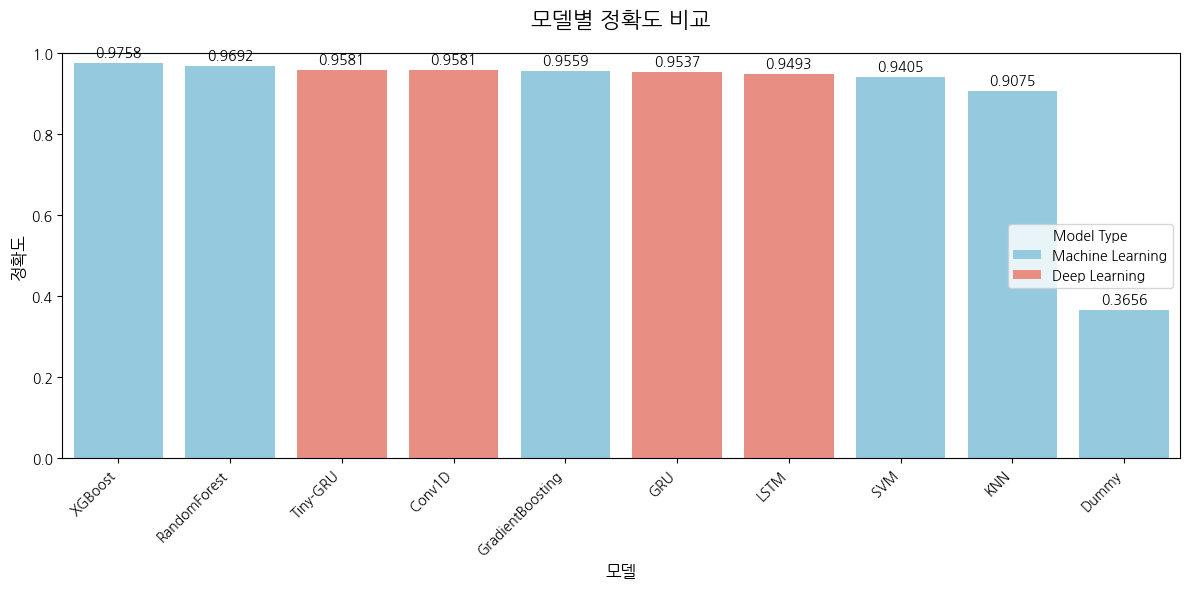


평가 완료


In [24]:
# ================================
# 모든 모델 평가 및 시각화
# ================================
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("\n" + "="*80)
print("모델 정확도 평가")
print("="*80)

# 정확도 저장할 딕셔너리
accuracy_results = {}

# 머신러닝 모델 평가 (2D 데이터 사용)
ml_models = {
    'RandomForest': rf_model,
    'SVM': svm_model,
    'XGBoost': xgb_model,
    'KNN': knn_model,
    'GradientBoosting': gbc_model,
    'Dummy': dummy_model
}

for name, model in ml_models.items():
    y_pred = model.predict(X_test_2d)
    acc = accuracy_score(y_test, y_pred)
    accuracy_results[name] = acc
    print(f"{name}: {acc:.4f}")

# 딥러닝 모델 평가 (3D 데이터 사용)
dl_models = {
    "LSTM":    os.path.join(SAVE_MODEL_DIR, "lstm_model.h5"),
    "GRU":     os.path.join(SAVE_MODEL_DIR, "gru_model.h5"),
    "Tiny-GRU": os.path.join(SAVE_MODEL_DIR, "tiny-gru_model.h5"),
    "Conv1D":  os.path.join(SAVE_MODEL_DIR, "conv1d_model.h5"),
}


for name, path in dl_models.items():
    model = tf.keras.models.load_model(path)
    y_pred = model.predict(X_test_3d, verbose=0)
    y_pred_classes = y_pred.argmax(axis=1)
    acc = accuracy_score(y_test, y_pred_classes)
    accuracy_results[name] = acc
    print(f"{name}: {acc:.4f}")

# 정확도 기준 내림차순 정렬
sorted_results = sorted(accuracy_results.items(), key=lambda x: x[1], reverse=True)
sorted_df = pd.DataFrame(sorted_results, columns=['Model', 'Accuracy'])

# 모델 타입 컬럼 추가
sorted_df['Model Type'] = sorted_df['Model'].apply(lambda x:
    'Deep Learning' if x in dl_models else 'Machine Learning')

print("\n" + "="*80)
print("정확도 순위")
print("="*80)
print(sorted_df.to_string(index=False))

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=sorted_df, x='Model', y='Accuracy', hue='Model Type', palette={'Machine Learning': 'skyblue', 'Deep Learning': 'salmon'})
plt.title('모델별 정확도 비교', fontsize=16, pad=20)
plt.xlabel('모델', fontsize=12)
plt.ylabel('정확도', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)

# 막대 위에 정확도 값 표시
for i, (model, acc) in enumerate(sorted_results):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("평가 완료")
print("="*80)



모델별 컨퓨전 매트릭스

=== Confusion Matrix: RandomForest ===
[[101   0   0]
 [  1 224   2]
 [  0  11 115]]


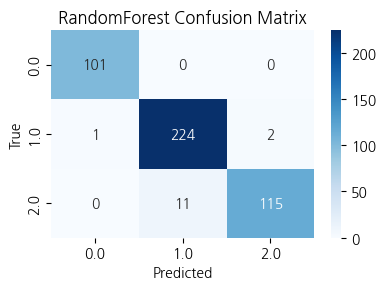


=== Confusion Matrix: SVM ===
[[101   0   0]
 [  3 220   4]
 [  1  19 106]]


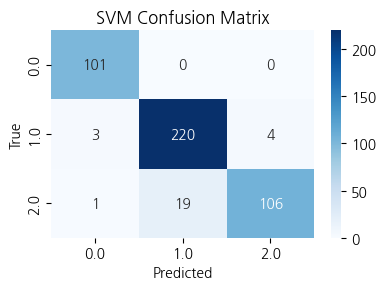


=== Confusion Matrix: XGBoost ===
[[101   0   0]
 [  1 224   2]
 [  0   8 118]]


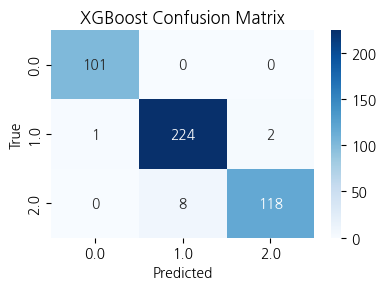


=== Confusion Matrix: KNN ===
[[101   0   0]
 [  3 212  12]
 [  0  27  99]]


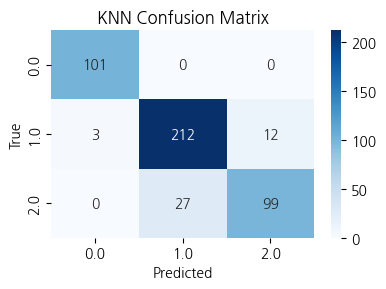


=== Confusion Matrix: GradientBoosting ===
[[100   0   1]
 [  1 220   6]
 [  0  12 114]]


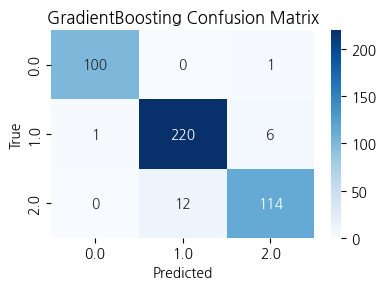


=== Confusion Matrix: Dummy ===
[[ 13  64  24]
 [ 50 114  63]
 [ 23  64  39]]


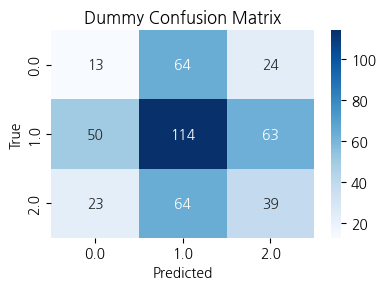


=== Confusion Matrix: LSTM ===
[[101   0   0]
 [  2 215  10]
 [  0  11 115]]


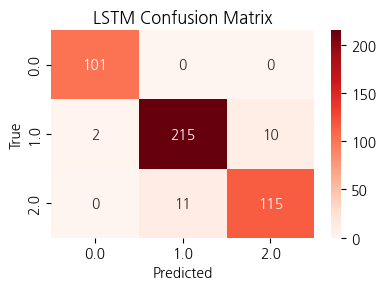


=== Confusion Matrix: GRU ===
[[101   0   0]
 [  2 219   6]
 [  0  13 113]]


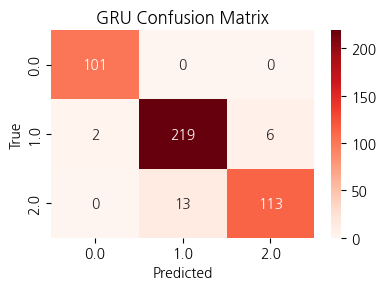


=== Confusion Matrix: Tiny-GRU ===
[[101   0   0]
 [  3 217   7]
 [  0   9 117]]


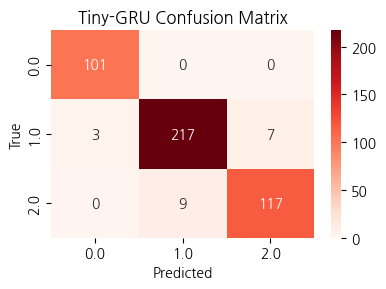


=== Confusion Matrix: Conv1D ===
[[101   0   0]
 [  3 218   6]
 [  0  10 116]]


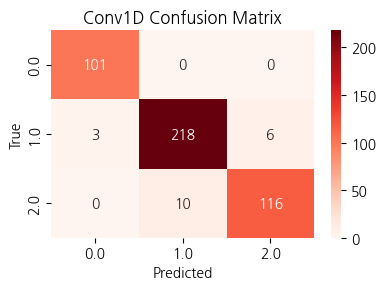

In [25]:
from sklearn.metrics import confusion_matrix

print("\n" + "="*80)
print("모델별 컨퓨전 매트릭스")
print("="*80)

# 클래스 라벨 (예: 0,1,2)
classes = sorted(np.unique(y_test))

# 1) 머신러닝 모델 컨퓨전 매트릭스
for name, model in ml_models.items():
    y_pred = model.predict(X_test_2d)
    cm = confusion_matrix(y_test, y_pred, labels=classes)

    print(f"\n=== Confusion Matrix: {name} ===")
    print(cm)

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

# 2) 딥러닝 모델 컨퓨전 매트릭스
for name, path in dl_models.items():
    model = tf.keras.models.load_model(path)
    y_pred = model.predict(X_test_3d, verbose=0)
    y_pred_classes = y_pred.argmax(axis=1)
    cm = confusion_matrix(y_test, y_pred_classes, labels=classes)

    print(f"\n=== Confusion Matrix: {name} ===")
    print(cm)

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
                xticklabels=classes, yticklabels=classes)
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()


In [26]:
import os

# 현재 작업 디렉토리 확인
print("현재 작업 디렉토리:", os.getcwd())

# 현재 디렉토리의 파일 목록 확인
print("\n현재 디렉토리 파일들:")
print(os.listdir('.'))

현재 작업 디렉토리: /home/gyuha1118/venvs/capstone/code

현재 디렉토리 파일들:
['best_model', 'saved_models', '딥러닝 머신러닝 모델 비교.ipynb', '.ipynb_checkpoints', 'datasets', 'processed_features.npz', 'xgboost_정제 데이터 적용.ipynb', '딥러닝 시계열 데이터셋 학습.ipynb']


In [27]:
import numpy as np

# 몇 개까지 출력할지
N_SHOW = 50

# saved_models 폴더 경로 설정
model_dir = "saved_models"
model_path = os.path.join(model_dir, "gru_model.h5")

# y_test를 numpy 배열로 통일
y_test_arr = y_test.to_numpy() if hasattr(y_test, "to_numpy") else np.array(y_test)

# ==============================
# 1) 머신러닝 모델 (예: RandomForest)
# ==============================
ml_model = rf_model          # 다른 모델이면 여기만 바꾸면 됨
X_ml = X_test_2d

proba_ml = ml_model.predict_proba(X_ml)       # (샘플 수, 클래스 수)
proba_ml_round = np.round(proba_ml, 2)        # 소수 둘째자리까지 반올림
y_ml_pred = proba_ml_round.argmax(axis=1)

print("\n=== RandomForest 예측 (반올림된 확률) ===")
for i in range(min(N_SHOW, len(y_test_arr))):
    print(f"샘플 {i}:  실제={y_test_arr[i]},  예측={y_ml_pred[i]},  확률={proba_ml_round[i]}")

# ==============================
# 2) 딥러닝 모델 (예: GRU)
# ==============================
if os.path.exists(model_path):
    dl_model = tf.keras.models.load_model(model_path)
    X_dl = X_test_3d
    
    proba_dl = dl_model.predict(X_dl, verbose=0)
    proba_dl_round = np.round(proba_dl, 2)
    y_dl_pred = proba_dl_round.argmax(axis=1)
    
    print("\n=== GRU 예측 (반올림된 확률) ===")
    for i in range(min(N_SHOW, len(y_test_arr))):
        print(f"샘플 {i}:  실제={y_test_arr[i]},  예측={y_dl_pred[i]},  확률={proba_dl_round[i]}")


=== RandomForest 예측 (반올림된 확률) ===
샘플 0:  실제=0.0,  예측=0,  확률=[1. 0. 0.]
샘플 1:  실제=0.0,  예측=0,  확률=[1. 0. 0.]
샘플 2:  실제=0.0,  예측=0,  확률=[1. 0. 0.]
샘플 3:  실제=1.0,  예측=1,  확률=[0. 1. 0.]
샘플 4:  실제=1.0,  예측=1,  확률=[0.   0.97 0.03]
샘플 5:  실제=2.0,  예측=2,  확률=[0.   0.06 0.94]
샘플 6:  실제=0.0,  예측=0,  확률=[1. 0. 0.]
샘플 7:  실제=1.0,  예측=1,  확률=[0.   0.99 0.01]
샘플 8:  실제=1.0,  예측=2,  확률=[0.02 0.4  0.58]
샘플 9:  실제=0.0,  예측=0,  확률=[1. 0. 0.]
샘플 10:  실제=1.0,  예측=1,  확률=[0. 1. 0.]
샘플 11:  실제=2.0,  예측=2,  확률=[0.   0.38 0.62]
샘플 12:  실제=0.0,  예측=0,  확률=[1. 0. 0.]
샘플 13:  실제=0.0,  예측=0,  확률=[1. 0. 0.]
샘플 14:  실제=0.0,  예측=0,  확률=[1. 0. 0.]
샘플 15:  실제=0.0,  예측=0,  확률=[1. 0. 0.]
샘플 16:  실제=1.0,  예측=1,  확률=[0.   0.98 0.02]
샘플 17:  실제=2.0,  예측=2,  확률=[0.   0.04 0.96]
샘플 18:  실제=0.0,  예측=0,  확률=[1. 0. 0.]
샘플 19:  실제=2.0,  예측=2,  확률=[0.   0.42 0.58]
샘플 20:  실제=2.0,  예측=2,  확률=[0.   0.25 0.75]
샘플 21:  실제=1.0,  예측=1,  확률=[0.04 0.96 0.  ]
샘플 22:  실제=2.0,  예측=2,  확률=[0.01 0.45 0.54]
샘플 23:  실제=1.0,  예측=1,  확률=[0.   0.

In [28]:
# import numpy as np

# # y_test를 numpy 배열로 통일
# y_test_arr = y_test.to_numpy() if hasattr(y_test, "to_numpy") else np.array(y_test)

# # 애매한 예측 기준
# max_thr = 0.6     # 최대 확률이 이 값보다 작으면 애매
# margin_thr = 0.15 # top1 - top2 확률 차이가 이 값보다 작으면 애매

# def find_ambiguous_indices(proba, max_thr=0.6, margin_thr=0.15):
#     """
#     proba: (n_samples, n_classes) 예측 확률
#     max_thr: 최대 확률 기준
#     margin_thr: top1 - top2 차이 기준
#     """
#     max_p = proba.max(axis=1)          # 각 샘플의 최대 확률
#     sorted_p = np.sort(proba, axis=1)  # 작은 것→큰 것 정렬
#     second_p = sorted_p[:, -2]         # 두 번째로 큰 확률
#     margin = max_p - second_p          # top1 - top2 차이

#     mask = (max_p < max_thr) | (margin < margin_thr)
#     idx = np.where(mask)[0]
#     return idx, max_p[mask], margin[mask]

# # ==============================
# # 1) RandomForest (머신러닝)
# # ==============================
# ml_model = rf_model
# X_ml = X_test_2d

# proba_ml = ml_model.predict_proba(X_ml)       # (샘플 수, 클래스 수)
# amb_idx_ml, amb_max_ml, amb_margin_ml = find_ambiguous_indices(
#     proba_ml, max_thr=max_thr, margin_thr=margin_thr
# )
# y_ml_pred = proba_ml.argmax(axis=1)
# proba_ml_round = np.round(proba_ml, 2)

# print(f"\n=== RandomForest 애매한 예측 (총 {len(amb_idx_ml)}개) ===")
# for idx, max_p, mg in zip(amb_idx_ml, amb_max_ml, amb_margin_ml):
#     # X_ml이 DataFrame인지 ndarray인지에 따라 처리
#     x_row = X_ml.iloc[idx] if hasattr(X_ml, "iloc") else X_ml[idx]

#     print(f"\n[샘플 {idx}]")
#     print(f"실제 라벨   : {y_test_arr[idx]}")
#     print(f"예측 라벨   : {y_ml_pred[idx]}")
#     print(f"최대 확률   : {max_p:.2f}")
#     print(f"top1-top2 차: {mg:.2f}")
#     print(f"확률 벡터   : {proba_ml_round[idx]}")
#     print("입력 데이터 :")
#     print(x_row)

# # ==============================
# # 2) GRU (딥러닝)
# # ==============================
# dl_model = tf.keras.models.load_model("gru_model.h5")
# X_dl = X_test_3d

# proba_dl = dl_model.predict(X_dl, verbose=0)
# amb_idx_dl, amb_max_dl, amb_margin_dl = find_ambiguous_indices(
#     proba_dl, max_thr=max_thr, margin_thr=margin_thr
# )
# y_dl_pred = proba_dl.argmax(axis=1)
# proba_dl_round = np.round(proba_dl, 2)

# print(f"\n=== GRU 애매한 예측 (총 {len(amb_idx_dl)}개) ===")
# for idx, max_p, mg in zip(amb_idx_dl, amb_max_dl, amb_margin_dl):
#     seq = X_dl[idx]  # (타임스텝, 피처 수)

#     print(f"\n[샘플 {idx}]")
#     print(f"실제 라벨   : {y_test_arr[idx]}")
#     print(f"예측 라벨   : {y_dl_pred[idx]}")
#     print(f"최대 확률   : {max_p:.2f}")
#     print(f"top1-top2 차: {mg:.2f}")
#     print(f"확률 벡터   : {proba_dl_round[idx]}")
#     print(f"입력 시퀀스 shape: {seq.shape}")  # 예: (8, 4)
#     print("입력 시퀀스 값:")
#     print(seq)


# 모델이 맞추지 못한 데이터 삭제

- 기준 모델이 틀린 샘플
- 정답 라벨 확률 0.3 미만
- 해당 라벨에서 전체 샘플의 15% 이내만 삭제

In [29]:
# import os
# from datetime import datetime
# import numpy as np
# import pandas as pd

# # ------------------------------------------------------
# # 1. 전체 데이터(features_df) 기준으로 X, y 추출
# # ------------------------------------------------------
# X_all = features_df.drop(columns=['label'])
# y_all = features_df['label'].to_numpy(int)

# # 동일한 scaler로 전체 데이터 스케일링
# X_all_2d = scaler.transform(X_all)

# # ------------------------------------------------------
# # 2. 기준 모델(XGBoost)로 전체 데이터 예측
# # ------------------------------------------------------
# y_pred_all = xgb_model.predict(X_all_2d)
# proba_all  = xgb_model.predict_proba(X_all_2d)

# idx    = np.arange(len(y_all))
# p_true = proba_all[idx, y_all]      # 정답 라벨 확률
# p_pred = proba_all.max(axis=1)      # 가장 확신하는 라벨 확률

# # ------------------------------------------------------
# # 3. 삭제 마스크 생성
# #    조건: (1) 틀림 AND (2) p_true < 0.3 AND (3) p_pred > 0.6
# # ------------------------------------------------------
# is_wrong    = (y_pred_all != y_all)
# delete_mask = is_wrong & (p_true < 0.3) & (p_pred > 0.6)

# n_del = int(delete_mask.sum())
# n_all = len(delete_mask)
# print(f"삭제 대상: {n_del} / {n_all} (features_df 전체 기준)")

# if n_del == 0:
#     print("삭제 대상이 없어 CSV를 생성하지 않는다.")
# else:
#     # --------------------------------------------------
#     # 4. 삭제 / 유지 데이터프레임 분리
#     # --------------------------------------------------
#     delete_index = features_df.index[delete_mask]

#     df_deleted  = features_df.loc[delete_index].copy()
#     df_filtered = features_df.drop(index=delete_index).copy()

#     print(f"전체 {len(features_df)}개 중 삭제 {len(df_deleted)}개, 남는 데이터 {len(df_filtered)}개")

#     # --------------------------------------------------
#     # 5. datasets 폴더에 CSV 저장
#     #    파일명: deleted_YYMMDD_labeled_NH-001_301A.csv
#     # --------------------------------------------------
#     if '__file__' in globals():
#         base_dir = os.path.dirname(os.path.abspath(__file__))
#     else:
#         base_dir = os.getcwd()

#     datasets_dir = os.path.join(base_dir, "datasets")
#     os.makedirs(datasets_dir, exist_ok=True)

#     run_date = datetime.now().strftime("%y%m%d")
    
#     filtered_filename = f"filtered_{run_date}_labeled_NH-001_301A.csv"
#     filtered_path     = os.path.join(datasets_dir, filtered_filename)
#     df_filtered.to_csv(filtered_path, index=False, encoding="utf-8-sig")

#     print(f"삭제된 데이터 CSV 저장 완료: {deleted_path}")
#     print(f"필터된 전체 데이터셋 CSV 저장 완료: {filtered_path}")

# 새 테스트 데이터셋 적용

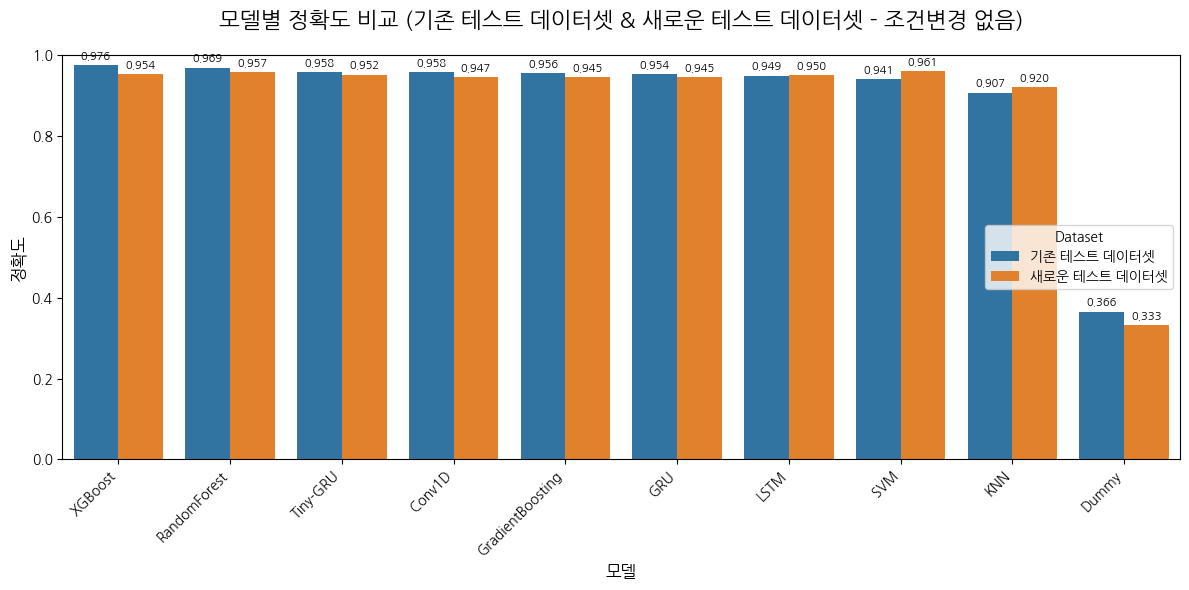

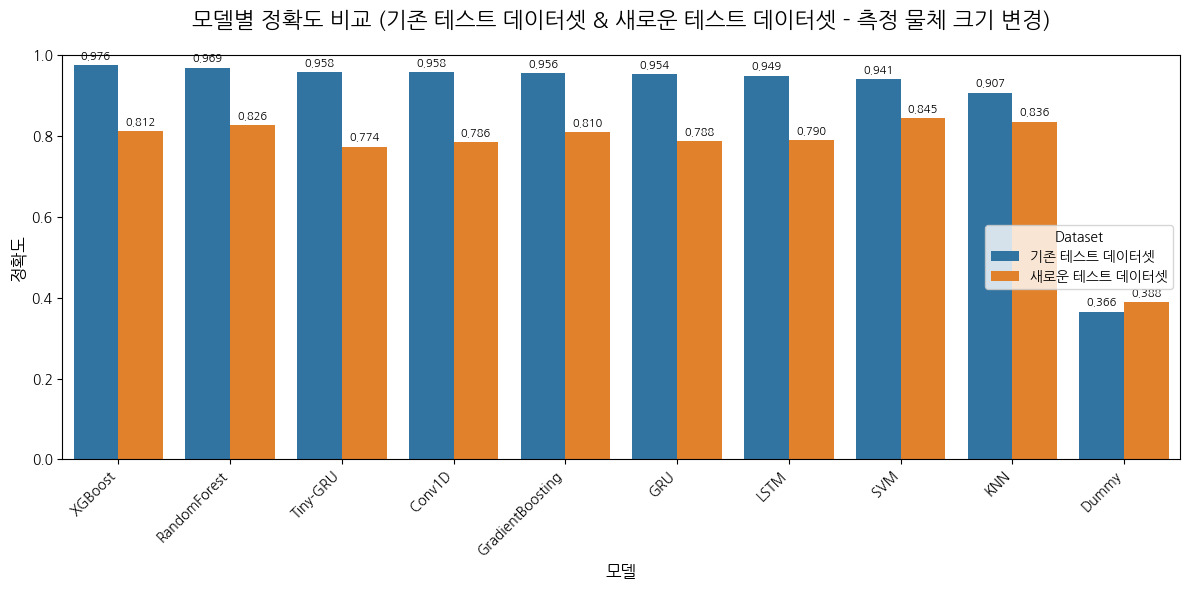

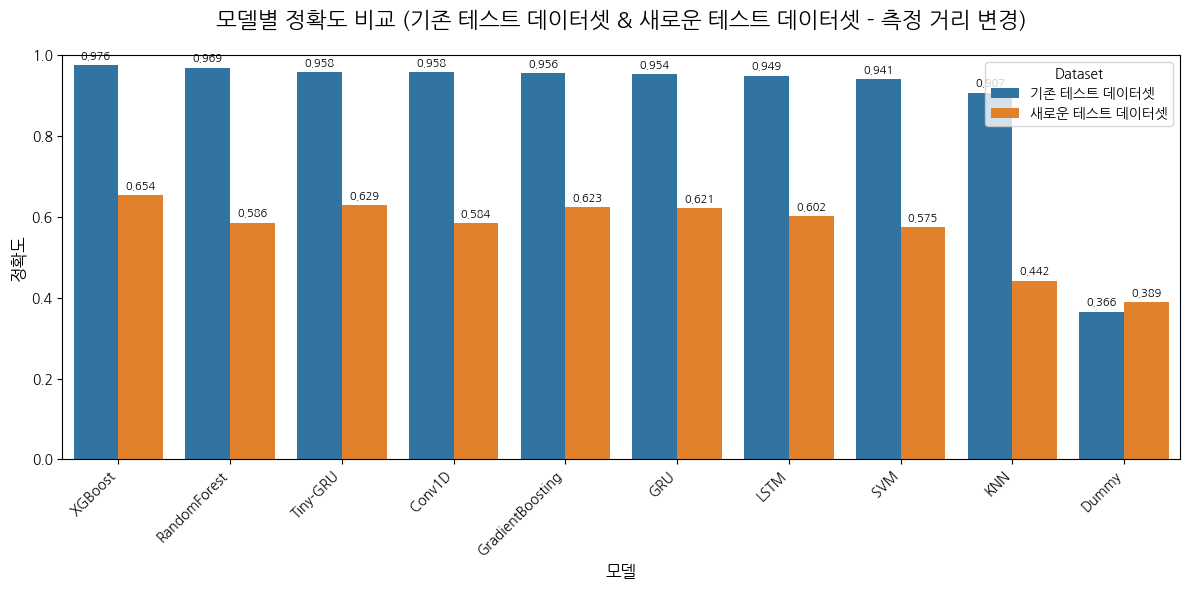

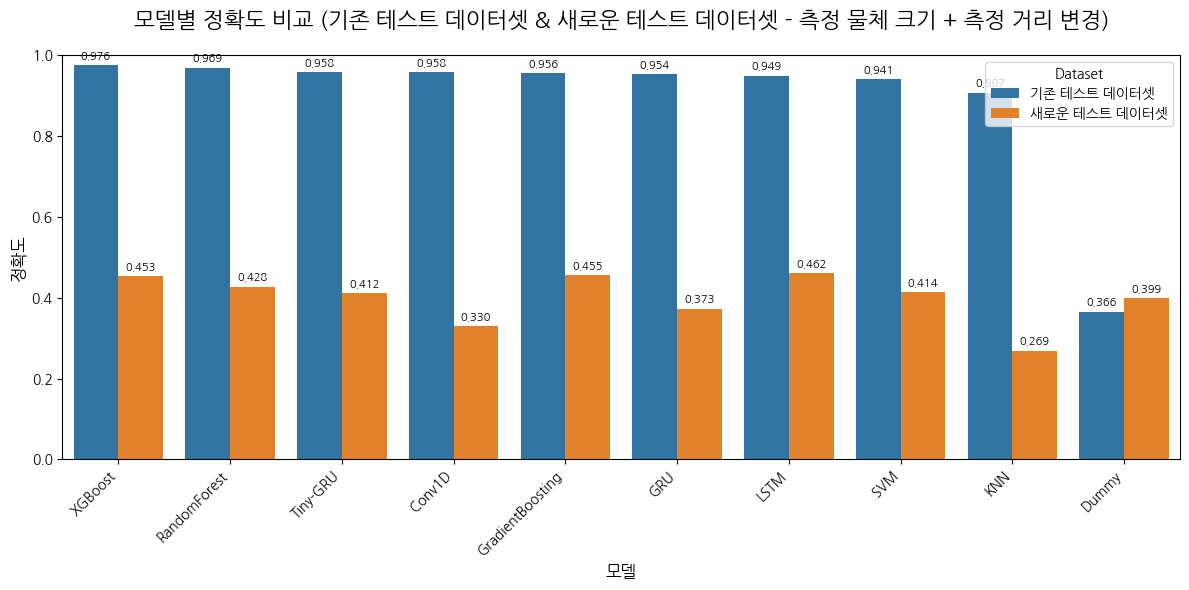

In [38]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# ---------------------------------------------------
# 0. 기존 테스트셋 결과 백업 (지금 accuracy_results가 기존 테스트셋 기준)
# ---------------------------------------------------
orig_accuracy_results = accuracy_results.copy()
orig_sorted_results = sorted(orig_accuracy_results.items(), key=lambda x: x[1], reverse=True)
model_order = [m for m, _ in orig_sorted_results]

# ---------------------------------------------------
# 1. 공통 전처리 + 윈도우 피처 추출 함수
#    (학습 파이프라인과 동일하게 맞춤)
# ---------------------------------------------------
def build_features_from_csv(csv_path):
    df = pd.read_csv(csv_path)

    # ESP32-* 컬럼 찾기
    esp_cols = [c for c in df.columns if c.startswith("ESP32-")]

    # 0, -1, '' -> NaN 후 float 변환
    for col in esp_cols:
        df[col] = df[col].replace([0, -1, ""], np.nan)
        df[col] = pd.to_numeric(df[col], errors="coerce").astype(float)

    # timestamp를 datetime으로
    df["timestamp"] = pd.to_datetime(df["timestamp"])

    # 라벨별 마스크
    mask_label_0   = (df["label"] == 0)
    mask_label_1_2 = (df["label"].isin([1, 2]))

    # 라벨 1/2: 대칭·평균 보간
    max_imputation_iterations = 10
    for _ in range(max_imputation_iterations):
        nan_count_this_iter = 0

        # ESP32-1 <-> ESP32-4 대칭 (39 기준)
        impute_mask_1 = mask_label_1_2 & df["ESP32-1"].isnull() & df["ESP32-4"].notnull()
        df.loc[impute_mask_1, "ESP32-1"] = 39 - df.loc[impute_mask_1, "ESP32-4"]
        nan_count_this_iter += impute_mask_1.sum()

        impute_mask_4 = mask_label_1_2 & df["ESP32-4"].isnull() & df["ESP32-1"].notnull()
        df.loc[impute_mask_4, "ESP32-4"] = 39 - df.loc[impute_mask_4, "ESP32-1"]
        nan_count_this_iter += impute_mask_4.sum()

        # ESP32-2: ESP32-3, ESP32-1 평균
        impute_mask_2 = (
            mask_label_1_2
            & df["ESP32-2"].isnull()
            & df["ESP32-3"].notnull()
            & df["ESP32-1"].notnull()
        )
        df.loc[impute_mask_2, "ESP32-2"] = (
            df.loc[impute_mask_2, "ESP32-3"] + df.loc[impute_mask_2, "ESP32-1"]
        ) / 2
        nan_count_this_iter += impute_mask_2.sum()

        # ESP32-3: ESP32-2, ESP32-4 평균
        impute_mask_3 = (
            mask_label_1_2
            & df["ESP32-3"].isnull()
            & df["ESP32-2"].notnull()
            & df["ESP32-4"].notnull()
        )
        df.loc[impute_mask_3, "ESP32-3"] = (
            df.loc[impute_mask_3, "ESP32-2"] + df.loc[impute_mask_3, "ESP32-4"]
        ) / 2
        nan_count_this_iter += impute_mask_3.sum()

        if nan_count_this_iter == 0:
            break

    # 라벨 0: 센서별 평균으로 채우기
    col_means = df[esp_cols].mean()
    for col in esp_cols:
        impute_mask_0 = mask_label_0 & df[col].isnull()
        df.loc[impute_mask_0, col] = col_means[col]

    # 연속 구간 나누기
    df["time_diff"] = df["timestamp"].diff().dt.total_seconds().round(2)
    break_indices = df[df["time_diff"] > 0.2].index

    continuous_blocks = []
    start_idx = 0
    for end_idx in break_indices:
        if end_idx > start_idx:
            continuous_blocks.append(df.iloc[start_idx:end_idx].copy())
        start_idx = end_idx + 1
    if start_idx < len(df):
        continuous_blocks.append(df.iloc[start_idx:].copy())

    # 윈도우 기반 feature 추출 (학습 파이프라인과 동일)
    extracted_features = []
    window_size = 8   # 1.6초 / 0.2초
    stride = 2        # 0.4초 간격

    for block in continuous_blocks:
        if len(block) >= window_size:
            for i in range(0, len(block) - window_size + 1, stride):
                window_data = block.iloc[i : i + window_size]
                if len(window_data) != window_size:
                    continue

                feature_dict = {}
                for col in esp_cols:
                    vals = window_data[col].to_numpy(dtype=float)

                    # 기본 통계
                    feature_dict[f"{col}_mean"]   = vals.mean()
                    feature_dict[f"{col}_std"]    = vals.std()
                    feature_dict[f"{col}_min"]    = vals.min()
                    feature_dict[f"{col}_max"]    = vals.max()
                    feature_dict[f"{col}_median"] = np.median(vals)

                    # 1) 윈도우 안 요동 크기
                    feature_dict[f"{col}_range"]           = vals.max() - vals.min()
                    feature_dict[f"{col}_first_last_diff"] = vals[-1] - vals[0]

                    # 2) 윈도우 안 속도/변화량
                    if len(vals) >= 2:
                        diffs = np.abs(np.diff(vals))          # |x_t - x_{t-1}|
                        feature_dict[f"{col}_mean_diff"] = diffs.mean()
                        feature_dict[f"{col}_max_diff"]  = diffs.max()
                    else:
                        feature_dict[f"{col}_mean_diff"] = 0.0
                        feature_dict[f"{col}_max_diff"]  = 0.0

                # 라벨: 최빈값
                label_mode = window_data["label"].mode()
                feature_dict["label"] = label_mode[0] if not label_mode.empty else np.nan

                extracted_features.append(feature_dict)

    features_df = pd.DataFrame(extracted_features).dropna(subset=["label"])
    return features_df


# ---------------------------------------------------
# 2. 공통 평가 함수 (머신러닝 + 딥러닝)
# ---------------------------------------------------
def eval_models_on_features(features_df):
    y = features_df["label"].astype(np.float32)
    X = features_df.drop("label", axis=1)

    # 기존에 학습해 둔 scaler 사용
    X_2d = scaler.transform(X).astype(np.float32)
    X_3d = X_2d.reshape(X_2d.shape[0], 1, X_2d.shape[1])

    acc_dict = {}

    # 머신러닝
    for name, model in ml_models.items():
        y_pred = model.predict(X_2d)
        acc_dict[name] = accuracy_score(y, y_pred)

    # 딥러닝
    for name, path in dl_models.items():
        dl_model = tf.keras.models.load_model(path)
        y_pred = dl_model.predict(X_3d, verbose=0)
        y_pred_cls = y_pred.argmax(axis=1)
        acc_dict[name] = accuracy_score(y, y_pred_cls)

    return acc_dict


# ---------------------------------------------------
# 3. 그래프 공통 함수
# ---------------------------------------------------
def plot_comparison(model_order, base_acc, new_acc,
                    base_label, new_label, title_text):
    rows = []
    for m in model_order:
        rows.append({
            "Model": m,
            "Dataset": base_label,
            "Accuracy": base_acc[m],
            "Model Type": "Deep Learning" if m in dl_models else "Machine Learning",
        })
        rows.append({
            "Model": m,
            "Dataset": new_label,
            "Accuracy": new_acc[m],
            "Model Type": "Deep Learning" if m in dl_models else "Machine Learning",
        })

    df_plot = pd.DataFrame(rows)
    df_plot["Model"] = pd.Categorical(
        df_plot["Model"],
        categories=model_order,
        ordered=True,
    )

    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=df_plot,
        x="Model",
        y="Accuracy",
        hue="Dataset",
    )
    plt.title(title_text, fontsize=16, pad=20)
    plt.xlabel("모델", fontsize=12)
    plt.ylabel("정확도", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.ylim(0, 1)

    for i, m in enumerate(model_order):
        acc_orig = base_acc[m]
        acc_new  = new_acc[m]
        plt.text(i - 0.2, acc_orig + 0.01, f"{acc_orig:.3f}", ha="center", va="bottom", fontsize=8)
        plt.text(i + 0.2, acc_new  + 0.01, f"{acc_new:.3f}",  ha="center", va="bottom", fontsize=8)

    plt.tight_layout()
    plt.show()


# ---------------------------------------------------
# 4. TEST CSV 4개 경로 + 설명
# ---------------------------------------------------
test_sets = {
    "no_change": {
        "path": "datasets/test Sets/251127_TEST_labeled_NH-001_301A.csv",
        "suffix": "조건변경 없음",
    },
    "small": {
        "path": "datasets/test Sets/251127_TEST_small size_labeled_NH-001_301A.csv",
        "suffix": "측정 물체 크기 변경",
    },
    "long": {
        "path": "datasets/test Sets/251127_long distance_labeled_NH-001_301A.csv",
        "suffix": "측정 거리 변경",
    },
    "small_long": {
        "path": "datasets/test Sets/251127_small size and long distance_labeled_NH-001_301A.csv",
        "suffix": "측정 물체 크기 + 측정 거리 변경",
    },
}


# ---------------------------------------------------
# 5. TEST 4개 전부 평가 + 그래프 4개 출력
#     기준: orig_accuracy_results  (기존 테스트 데이터셋)
# ---------------------------------------------------
for key, meta in test_sets.items():
    feats_new = build_features_from_csv(meta["path"])
    acc_new   = eval_models_on_features(feats_new)

    title = f"모델별 정확도 비교 (기존 테스트 데이터셋 & 새로운 테스트 데이터셋 - {meta['suffix']})"

    plot_comparison(
        model_order=model_order,
        base_acc=orig_accuracy_results,
        new_acc=acc_new,
        base_label="기존 테스트 데이터셋",
        new_label="새로운 테스트 데이터셋",
        title_text=title,
    )


# 모델 배포

주기적으로 데이터셋을 업데이트하여 모델을 학습 후 정확도가 높으면서 라즈베리파이에서 잘 작동할 수 있는 모델을 배포한다.

In [32]:
import joblib, json
import os

MODEL_DIR = "best_model"
os.makedirs(MODEL_DIR, exist_ok=True)

# 1) XGBoost 모델 저장 (이미 했다면 생략 가능)
joblib.dump(xgb_model, os.path.join(MODEL_DIR, "xgb_model.pkl"))

# 2) 스케일러 저장 (반드시 필요)
joblib.dump(scaler, os.path.join(MODEL_DIR, "scaler.pkl"))

# 3) 피처 순서 고정 (학습 때와 동일)
ULTRA_COLS = ["ESP32-1", "ESP32-2", "ESP32-3", "ESP32-4"]
STATS      = ["mean", "std", "min", "max", "median"]
FEATURE_ORDER = [f"{c}_{s}" for c in ULTRA_COLS for s in STATS]

with open(os.path.join(MODEL_DIR, "feature_order.json"), "w") as f:
    json.dump(FEATURE_ORDER, f)

print(f"끝")


끝
